## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Helper Function

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def load_from_pickle(file_path):
    """
    Load and return the Python object from a pickle file.
    
    Parameters:
    - file_path: str, the path to the pickle file to be loaded.
    
    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
    except Exception as e:
        print(f"An error occurred while loading the pickle file: {e}")

def plot_raster(sd):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    # Modify this function based on your grid conversion logic
    return pos[0], pos[1]  # Example conversion

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## Code to implement spatial activity profile method

### Helper functions

In [3]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles


def create_reverse_rank_lookup(event_ranks):
    """
    Create a reverse lookup table for event ranks.
    
    Parameters:
    - event_ranks: A dictionary mapping (neuron_id, spike_time) to event rank.
    
    Returns:
    - A dictionary mapping event rank to (neuron_id, spike_time).
    """
    reverse_lookup = {rank: (neuron_id, spike_time) for (neuron_id, spike_time), rank in event_ranks.items()}
    return reverse_lookup 

def calculate_event_ranks(spike_data, precision=5):
    # Flatten the list of spikes, rounding spike times, and sort by time
    # Include the original index of each spike for uniqueness
    all_spikes = [(neuron_id, round(spike_time, precision), idx) 
                  for neuron_id, spikes in enumerate(spike_data.train) 
                  for idx, spike_time in enumerate(spikes)]
                  
    # Sort by neuron_id, then rounded spike time, then original index
    all_spikes_sorted = sorted(all_spikes, key=lambda x: (x[1], x[0], x[2]))
    
    # Generate a dictionary with event rank as key, (neuron_id, spike_time) as value
    ranks = {rank: (neuron_id, spike_time) for rank, (neuron_id, spike_time, _) in enumerate(all_spikes_sorted)}
    
    print(f"Total unique events: {len(ranks)}")
    
    return ranks

def precompute_close_neurons(distances, window_size=17.5):
    # Initialize a dictionary to store the indices of close neurons for each neuron
    close_neurons = {}
    
    # Get the total number of neurons based on the distances matrix
    num_neurons = distances.shape[0]
    
    # Iterate over each neuron to find its close neighbors
    for i in range(num_neurons):
        # List comprehension to find neurons within the specified window size
        # Excludes the current neuron itself (i != j) and checks the distance condition
        close_neurons[i] = [
            j for j in range(num_neurons) 
            if i != j and distances[i, j] < window_size
        ]
        
    return close_neurons

def compute_bin_midpoints(bins):
    midpoints = (bins[:-1] + bins[1:]) / 2
    return midpoints

### Look at 30 events BEFORE

In [4]:
# Looking at 30 events BEFORE

def create_distance_angle_histograms_before(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        start_rank = max(0, current_event_id - rank_window)
        end_rank = current_event_id

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            if other_event_id == current_event_id:
                continue
            
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            # print("Distance: ", distance)
            angle = angles[current_neuron_id, other_neuron_id]
            # print("Angle: ", angle)

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Look at 30 events AFTER

In [5]:
# Looking at 30 events AFTER

def create_distance_angle_histograms_after(spike_data, event_ranks, spatial_range=(0, 500), rank_window=30, bins=6):
    total_events = len(event_ranks)
    histograms_per_event = {}

    distances, angles = precalculate_distances_angles(get_neuron_positions(spike_data))
    
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins+1)
    angle_bins = np.linspace(0, 2*np.pi, bins+1, endpoint=True)

    print_every_n = max(total_events // 10, 1)

    for current_event_id in event_ranks:
        if current_event_id % print_every_n == 0:
            print(f"Processing event {current_event_id} of {total_events}")

        # Adjust the rank window to look at events after the current event
        start_rank = current_event_id + 1  # Start from the next event
        end_rank = min(total_events, current_event_id + rank_window + 1)  # Ensure not to exceed the total events

        event_distances = []
        event_angles = []

        # Only consider events within the rank window
        for other_event_id in range(start_rank, end_rank):
            current_neuron_id = event_ranks[current_event_id][0]
            other_neuron_id = event_ranks[other_event_id][0]

            # Lookup distance and angle between the two neurons
            distance = distances[current_neuron_id, other_neuron_id]
            angle = angles[current_neuron_id, other_neuron_id]

            if np.abs(distance) < spatial_range[1]:
                event_distances.append(distance)
                event_angles.append(angle)
            
        event_angles = [0 if angle == 2*np.pi else angle for angle in event_angles]

        distance_hist, _ = np.histogram(event_distances, bins=distance_bins)
        angle_hist, _ = np.histogram(event_angles, bins=angle_bins)

        histograms_per_event[current_event_id] = {'distance': distance_hist, 'angle': angle_hist}

    print("Processing complete")
    return histograms_per_event

### Other processing

In [6]:
def compute_average_angle_from_histogram(angle_hist):
    # Check if the histogram sum is zero
    if np.sum(angle_hist) == 0:
        # Handle the case where the histogram sum is zero
        # For example, return None or raise an error
        return np.nan  # or consider raising an error or returning a default value

    bin_width = 360 / len(angle_hist)
    bin_midpoints = np.arange(0, 360, bin_width) + bin_width / 2
    bin_midpoints_radians = np.radians(bin_midpoints)

    x_components = angle_hist * np.cos(bin_midpoints_radians)
    y_components = angle_hist * np.sin(bin_midpoints_radians)

    x_mean = np.sum(x_components) / np.sum(angle_hist)
    y_mean = np.sum(y_components) / np.sum(angle_hist)

    # Compute the arctangent of the mean vector components to get the average angle in radians
    average_angle_radians = np.arctan2(y_mean, x_mean)

    # Normalize the average angle to be within 0 to 2*pi radians
    if average_angle_radians < 0:
        average_angle_radians += 2 * np.pi

    # Return the average angle in radians
    return average_angle_radians


# Function to take final histograms and calculate the average distance and angle for each event
def compute_average_distance_angle(final_histograms, spatial_range=(0, 10), bins=6):
    average_distances_angles = {}

    distance_midpoints = compute_bin_midpoints(np.linspace(spatial_range[0], spatial_range[1], bins+1))
    angle_midpoints = compute_bin_midpoints(np.linspace(0, 2*np.pi, bins+1))

    angle_midpoints_degrees = np.degrees(angle_midpoints)

    # print(angle_midpoints_degrees)

    for event_id, histograms in final_histograms.items():
        distance_hist = histograms['distance']
        angle_hist = histograms['angle']

        # Compute average distance
        distance_sum = np.sum(distance_hist * distance_midpoints)
        distance_count = np.sum(distance_hist)
        average_distance = distance_sum / distance_count if distance_count != 0 else 0

        # Compute average angle
        average_angle = compute_average_angle_from_histogram(angle_hist)

        normalized_average_angle = average_angle % (2 * np.pi)

        average_distances_angles[event_id] = {'distance': average_distance, 'angle': average_angle}

    return average_distances_angles

def all_events_per_neuron(spike_data, average_distances_angles_per_event):
    all_events_per_neuron = {}

    event_ranks = calculate_event_ranks(spike_data)
    for event_id, averages in average_distances_angles_per_event.items():
        neuron_id = event_ranks[event_id][0]
        if neuron_id not in all_events_per_neuron:
            all_events_per_neuron[neuron_id] = []
        all_events_per_neuron[neuron_id].append(averages)

    return all_events_per_neuron

def average_events_per_neuron(spike_data, average_distances_angles_per_event):
    events_per_neuron = all_events_per_neuron(spike_data, average_distances_angles_per_event)
    positions = get_neuron_positions(spike_data)

    average_events_per_neuron = {}
    for neuron_id, events in events_per_neuron.items():
        angles = [event['angle'] for event in events]
        distances = [event['distance'] for event in events]

        # Calculate vector components
        x_components = [distance * np.cos(angle) for distance, angle in zip(distances, angles)]
        y_components = [distance * np.sin(angle) for distance, angle in zip(distances, angles)]

        # Calculate average vector components
        x_mean = np.mean(x_components)
        y_mean = np.mean(y_components)

        # Convert average vector components to polar coordinates
        average_distance = np.sqrt(x_mean**2 + y_mean**2)
        average_angle = np.arctan2(y_mean, x_mean)

        # # Normalize the average angle to be within 0 to 2*pi radians
        # if average_angle < 0:
        #     average_angle += 2 * np.pi

        average_events_per_neuron[neuron_id] = {'distance': average_distance, 'angle': average_angle, 'position': positions[neuron_id]}

    return average_events_per_neuron

## PLOTTER

In [7]:
def plot_data(data, title):
    """
    Plots data points with arrows indicating direction and distance.
    Points with 'nan' angles are skipped in arrow plotting.

    Parameters:
    - data: A dictionary where each key is an identifier and each value is a dictionary
            containing 'distance', 'angle', and 'position'.
    """
    # Adjusting the plot with specified modifications: narrower, less bold arrows, and red neurons
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility
    for key, value in data.items():
        position = np.array(value['position'])  # Ensure position is a numpy array
        angle = value['angle']
        distance = value['distance'] # Scaling down the distance for better visualization

        # Plotting the point in red
        ax.plot(position[0], position[1], 'o', color='red')

        # Skip plotting the arrow if angle is nan
        if not np.isnan(angle):
            # Calculate the end point of the arrow
            end_point = position - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            
            # Plotting the arrow with narrower and less bold appearance
            ax.annotate('', xy=end_point, xytext=position,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

    ax.set_aspect('equal')
    # Invert y axis
    ax.invert_yaxis()
    ax.set_title(title)
    plt.show()

## Data

In [8]:
from human_hip import spike_data

hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/kilosort2/hc11.1_plated-11.1_chip-16753_rec_11.2.22AM-immediate_curated.zip')
hc_112823 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base_acqm.zip')
hc_112823_2 = spike_data.read_autocurated_data('/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112723_hckcr1_21841_120323_base2_acqm.zip')
hc_120523_chip21769 = read_phy_files("/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/elliott/elliott_chip21769_base.zip")

hc_328 = transform_neuron_data(hc_328)
hc_52 = transform_neuron_data(hc_52)
hc_111 = transform_neuron_data(hc_111)
hc_112823 = transform_neuron_data(hc_112823)
hc_112823_2 = transform_neuron_data(hc_112823_2)
hc_120523_chip21769 = transform_neuron_data(hc_120523_chip21769)

/tmp/ipykernel_560/3302845650.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_328 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated_s1.zip')
/tmp/ipykernel_560/3302845650.py:4: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_52 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-05-10-e-hc52_18790_unperturbed/derived/kilosort2/hc5.2_chip18790_baseline_rec5.10.23_curated_s1.zip')
/tmp/ipykernel_560/3302845650.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  hc_111 = read_phy_files('/workspaces/human_hippocampus/data/ephys/2022-11-02-e-Hc11.1-chip16753/derived/k

In [9]:
def analyze_spike_data(spikedata, spatial_range=(0, 50), rank_window=500, bins=6):
    """
    Analyzes spike data to compute histograms and averages before and after certain events.

    Parameters:
    - spikedata: The spike data to analyze.
    - spatial_range: A tuple defining the spatial range to consider.
    - rank_window: The rank window size for event calculation. Default is 500.
    - bins: The number of bins for histograms. Default is 6.

    Returns:
    A dictionary containing the before and after averages for distances, angles, and events per neuron.
    """
    # Calculate event ranks
    event_ranks = calculate_event_ranks(spikedata)
    
    # Create histograms
    before_histograms = create_distance_angle_histograms_before(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    after_histograms = create_distance_angle_histograms_after(spikedata, event_ranks, spatial_range=spatial_range, rank_window=rank_window, bins=bins)
    
    # Compute averages
    before_average_distances_angles = compute_average_distance_angle(before_histograms, spatial_range=spatial_range, bins=bins)
    after_average_distances_angles = compute_average_distance_angle(after_histograms, spatial_range=spatial_range, bins=bins)
    
    # Average events per neuron
    before_average_events_per_neuron = average_events_per_neuron(spikedata, before_average_distances_angles)
    after_average_events_per_neuron = average_events_per_neuron(spikedata, after_average_distances_angles)
    
    return before_average_events_per_neuron, after_average_events_per_neuron

In [10]:
hc_111_data = analyze_spike_data(hc_111, spatial_range=(0, 200), rank_window=20, bins=6)
hc_52_data = analyze_spike_data(hc_52, spatial_range=(0, 200), rank_window=20, bins=6)
hc_328_data = analyze_spike_data(hc_328, spatial_range=(0, 200), rank_window=20, bins=6)
hc_112823_data = analyze_spike_data(hc_112823, spatial_range=(0, 200), rank_window=20, bins=6)
hc_112823_2_data = analyze_spike_data(hc_112823_2, spatial_range=(0, 200), rank_window=20, bins=6)
hc_120523_data = analyze_spike_data(hc_120523_chip21769, spatial_range=(0, 200), rank_window=20, bins=6)

Total unique events: 49667
Processing event 0 of 49667


/tmp/ipykernel_560/2876065909.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


Processing event 4966 of 49667
Processing event 9932 of 49667
Processing event 14898 of 49667
Processing event 19864 of 49667
Processing event 24830 of 49667
Processing event 29796 of 49667
Processing event 34762 of 49667
Processing event 39728 of 49667
Processing event 44694 of 49667
Processing event 49660 of 49667
Processing complete
Processing event 0 of 49667
Processing event 4966 of 49667
Processing event 9932 of 49667
Processing event 14898 of 49667
Processing event 19864 of 49667
Processing event 24830 of 49667
Processing event 29796 of 49667
Processing event 34762 of 49667
Processing event 39728 of 49667
Processing event 44694 of 49667
Processing event 49660 of 49667
Processing complete
Total unique events: 49667
Total unique events: 49667
Total unique events: 21747
Processing event 0 of 21747
Processing event 2174 of 21747
Processing event 4348 of 21747
Processing event 6522 of 21747
Processing event 8696 of 21747
Processing event 10870 of 21747
Processing event 13044 of 21747

In [67]:
def combined_arrow_plots(data_info):
    nrows, ncols = 6, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(8, 14))

    for idx, (data, title, is_rotated, x_window, y_window) in enumerate(data_info):
        ax = axs[idx // ncols, idx % ncols]

        # Determine neuron color based on column
        neuron_color = 'lightblue' if idx % ncols == 0 else 'red'

        # Prepare positions and optionally rotate
        positions = np.array([value['position'] for value in data.values()])
        if is_rotated:
            positions = positions[:, ::-1]  # Swap x and y for rotation
            angles = [value['angle'] + np.pi/2 for value in data.values()]
        else:
            angles = [value['angle'] for value in data.values()]

        # Plot neurons with the determined color
        ax.scatter(positions[:, 0], positions[:, 1], color=neuron_color, s=12)

        # Plot arrows
        for pos, angle, value in zip(positions, angles, data.values()):
            if np.isnan(angle): continue
            distance = value['distance']
            end_pos = pos - np.array([np.cos(angle) * distance, np.sin(angle) * distance])
            ax.annotate('', xy=end_pos, xytext=pos,
                        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5, headlength=5))

        ax.axis('equal')
        ax.set_xlim(x_window)
        ax.set_ylim(y_window)

        # Write dataset name to the left of the left plot in each row
        if idx % ncols == 0:  # This is a left column plot
            ax.text(-0.15, 0.5, title, transform=ax.transAxes, rotation=90, va='center', ha='right')

    # Label columns at the top
    axs[0, 0].set_title('Average Activity Before')
    axs[0, 1].set_title('Average Activity After')

    plt.tight_layout(pad=0.5)
    plt.show()

In [61]:
# datasets = [hc_328_data[0], hc_328_data[1], hc_52_data[0], hc_52_data[1], hc_111_data[0], hc_111_data[1]]
# titles = ['HC 328 Before', 'HC 328 After', 'HC 52 Before', 'HC 52 After', 'HC 111 Before', 'HC 111 After']

# Example data_info format
# data_info = [
#     # (data, title, is_rotated) for each subplot
#     # Ensure 'data' is a dictionary where each key corresponds to a neuron and
#     # each value is a dict with 'position': (x, y), 'angle': angle_in_radians, 'distance': distance_of_arrow
#     (hc_328_data[0], 'HC 328 Before', True, (100, 1500), (0, 500)),
#     (hc_328_data[1], 'HC 328 After', True, (100, 1500), (0, 500)),
#     (hc_52_data[0], 'HC 52 Before', False, (100, 1500), (0, 500)),
#     (hc_52_data[1], 'HC 52 After', False, (100, 1500), (0, 500)),
#     (hc_111_data[0], 'HC 111 Before', False, (100, 1500), (0, 500)),
#     (hc_111_data[1], 'HC 111 After', False, (100, 1500), (0, 500))
# ]

data_info = [
    (hc_328_data[0], 'HC 328', True, (250, 1500), (1000, 1500)),
    (hc_328_data[1], 'HC 328 After', True, (250, 1500), (1000, 1500)),
    (hc_52_data[0], 'HC 52', False, (2250, 4000), (300, 1200)),
    (hc_52_data[1], 'HC 52 After', False, (2250, 4000), (300, 1200)),
    (hc_111_data[0], 'HC 111', False, (1800, 2700), (500, 1200)),
    (hc_111_data[1], 'HC 111 After', False, (1800, 2700), (500, 1200)),
    (hc_112823_data[0], 'HC 112823', False, (300, 1300), (800, 1300)),
    (hc_112823_data[1], 'HC 112823 After', False, (300, 1300), (800, 1300)),
    (hc_112823_2_data[0], 'HC 112823 2', False, (300, 1600), (800, 1500)),
    (hc_112823_2_data[1], 'HC 112823 2 After', False, (300, 1600), (800, 1500)),
    (hc_120523_data[0], 'HC 120523', False, (2600, 3100), (400, 900)),
    (hc_120523_data[1], 'HC 120523 After', False, (2500, 3200), (400, 900))
]


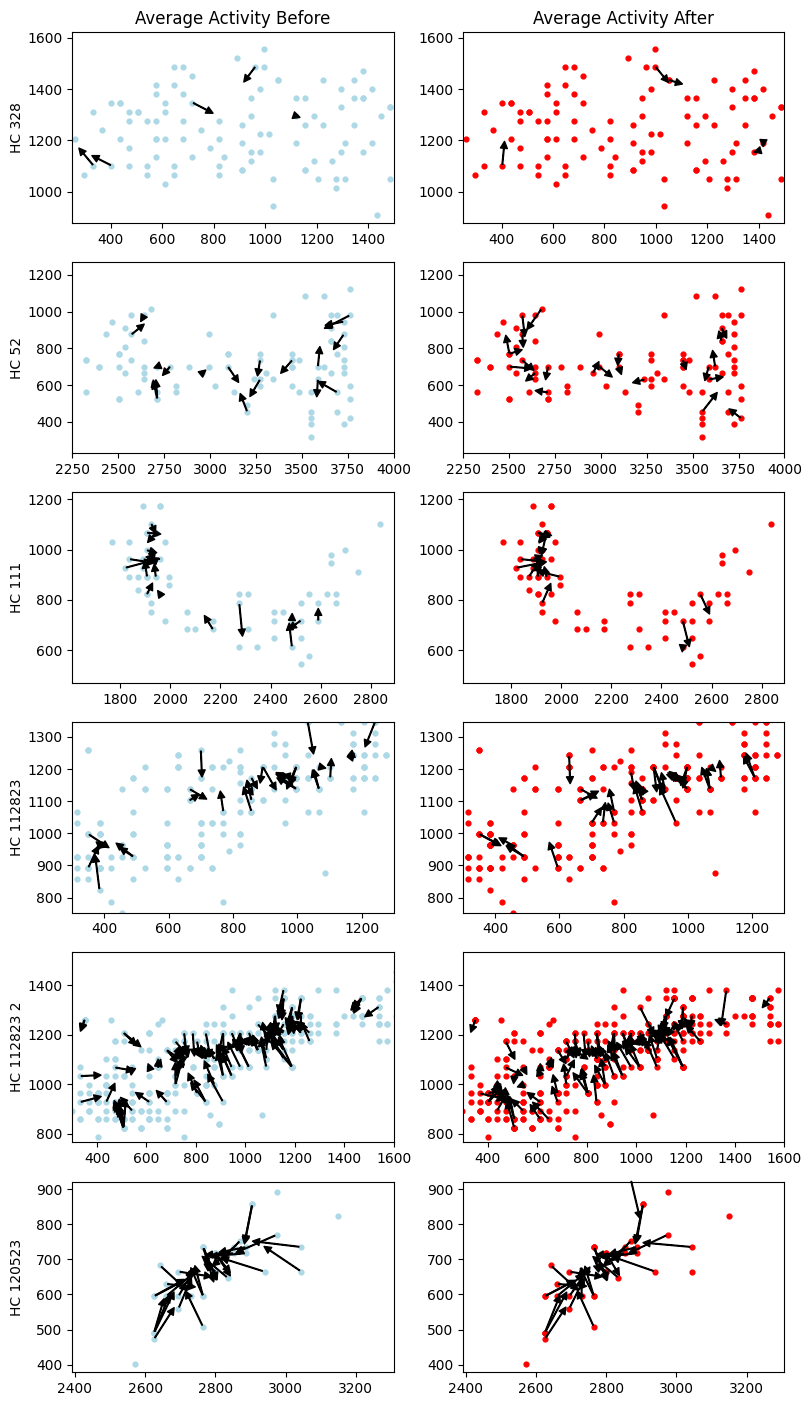

In [68]:
combined_arrow_plots(data_info)

In [114]:
def plot_combined_polar_histograms(datasets):
    """
    Plots polar histograms of angles for each pair of datasets in 'datasets', arranged in a 2x3 grid.
    Each dataset pair's name is used as the title for its plot.
    There is one common legend for the entire figure.
    The radius axis is removed from each plot.
    
    Parameters:
    - datasets: A list of tuples, where each tuple contains two datasets followed by the dataset's name.
    """
    fig, axs = plt.subplots(2, 3, figsize=(8, 4), subplot_kw={'polar': True})
    axs = axs.flatten()  # Flatten to make it easier to iterate over
    
    colors = ['blue', 'red']
    labels = ['Average Incoming Activity', 'Average Outgoing Activity']
    legend_added = False  # To ensure the legend is only added once
    
    for idx, (data1, data2, name) in enumerate(datasets):
        ax = axs[idx]
        hc_52_data = [data1, data2]  # Pair the datasets for processing
        
        for i, color in enumerate(colors):
            angles = [info['angle'] for info in hc_52_data[i].values() if not np.isnan(info['angle'])]
            n_bins = 6
            ax.hist(angles, bins=n_bins, density=True, alpha=0.6, color=color, label=labels[i] if not legend_added else "")
            
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_title(name)
        ax.set_yticklabels([])  # Remove the radius axis
        
        # if not legend_added:  # Add a common legend to the first subplot and don't add it again
        #     ax.legend(loc='lower left', bbox_to_anchor=(1.5, 1.1), fontsize='small')
        #     legend_added = True
    
    plt.tight_layout(pad=0.5)
    plt.show()

In [112]:
datasets = [
    [hc_328_data[0], hc_328_data[1], 'HC_328'],
    [hc_52_data[0], hc_52_data[1], 'HC_52'],
    [hc_111_data[0], hc_111_data[1], 'HC_111'],
    [hc_112823_data[0], hc_112823_data[1], 'HC_112823'],
    [hc_112823_2_data[0], hc_112823_2_data[1], 'HC_112823_2'],
    [hc_120523_data[0], hc_120523_data[1], 'HC_120523']
]

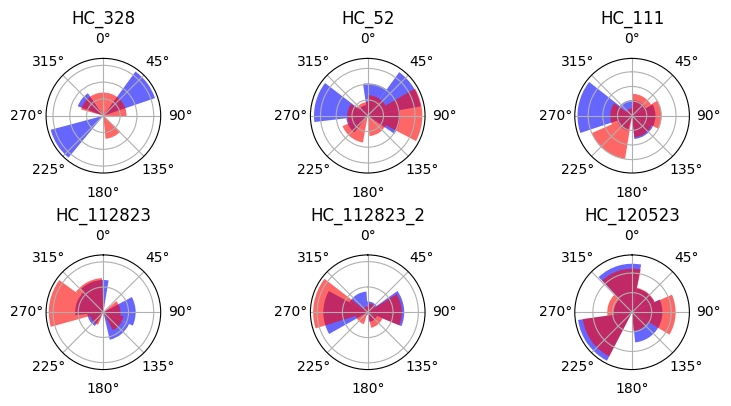

In [115]:
plot_combined_polar_histograms(datasets)